Recent 12hours rate
Datetime
2020-10-30 12:00    104.470
2020-10-30 13:00    104.510
2020-10-30 14:00    104.637
2020-10-30 15:00    104.552
2020-10-30 16:00    104.562
2020-10-30 17:00    104.656
2020-10-30 18:00    104.684
2020-10-30 19:00    104.701
2020-10-30 20:00    104.620
2020-11-01 22:00    104.633
2020-11-01 23:00    104.582
2020-11-02 00:00    104.657
Name: Close, dtype: object

Low/High
[79, 66]
The following is the accuracy during 1days.
accuracy_score: 0.46218487394957986
precision_score: [0.453125   0.47272727]
[[29 29]
 [35 26]]


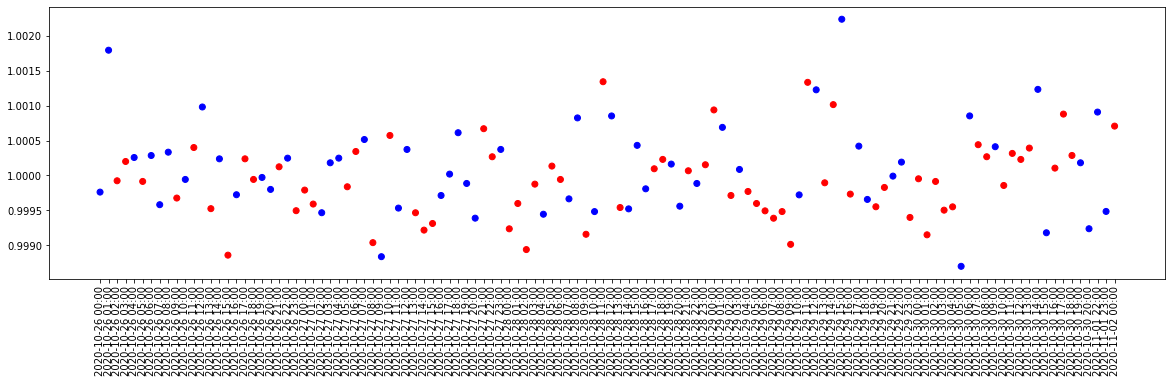

next is DOWN


In [3]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import time


#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")
        
# Oandaからcandleデータを取得する。
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    data = []
    for res in JSONRes['candles']:
        temp = [(datetime.datetime.fromisoformat(res['time'][:19])).strftime('%Y-%m-%d %H:%M')]#indexとなる時間を追加
        
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).hour]) #時間を追加
                
        temp.extend([datetime.datetime.fromisoformat(res['time'][:19]).day])  #日を追加
        
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data




def select_data(period_hours=24, money='USD_JPY', foot = 'H1'):
    all_data = []
    
    NY = datetime.timedelta(hours=-14)
    
    date_from = datetime.datetime.now()+datetime.timedelta(hours=-period_hours) + NY
    date_to = datetime.datetime.now() + NY + datetime.timedelta(seconds=-1)

    ret = getCandleDataFromOanda(money, api, date_from, date_to, foot)
    month_data = oandaJsonToPythonList(ret)#取得したデータを格納

    all_data.extend(month_data)#データを追加

    # pandas DataFrameへ変換
    df = pd.DataFrame(all_data)

    df.columns = ['Datetime',"hour_range",
                  "day",
                  'Volume', 'Open', 'High', 'Low', 'Close']
    df = df.set_index('Datetime')
    
    return df

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import talib as ta

def adjust_data(df):
    df.astype(float)
    #以降全ての計算でレート終値を使う
    close = np.array(df["Close"]).astype(float)
    
    #特徴量を入れるための空のdataframeを作成
    df_feature = pd.DataFrame()
    df_feature["log_C/O"] = np.log10(df["Close"].astype(float)/df["Open"].astype(float))
    #df_feature["hour_range"] = df["hour_range"]
    #df_feature["day"] = df["day"]
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる
    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    df_feature["SMA/current"]= ta.SMA(close, timeperiod=5) / close
    #RSI
    df_feature["RSI"] = ta.RSI(close, timeperiod=12)
    #MACD
    df_feature["MACD"], _ , _= ta.MACD(close, fastperiod=3, slowperiod=18, signalperiod=9)
    #ボリンジャーバンド 
    upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
    df_feature["BBANDS+2σ"] = upper / close.astype(float)
    df_feature["BBANDS-2σ"] = lower / close.astype(float)
    
    df_feature["ROC"] = ta.ROCP(close) / close
    
    c=[0,0]

    # High,Low分類
    def classify(x):
        if x<=0:
            c[0]+=1
            return 0
        elif 0<x:
            c[1]+=1
            return 1

    classified = pd.DataFrame(columns=["class"])  #分類結果を格納
    classified["class"] = (np.log10(df["Close"].astype(float)/df["Open"].astype(float))).apply(lambda x: classify(x))

    shift = 1
    
    classified = classified.shift(-shift)  #分類結果をずらす

#     df_adjusted=df_feature[70:len(df_feature)-shift]
#     classified=classified[70:len(classified)-shift]
    
    #print(df_adjusted)
    #print(classified.isnull().sum())
    print("Low/High")
    print(c)
    
    return df_feature, classified


from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import pickle

def predict(now_df, filename = 'RF_01.sav', day=1):
    
    day = 1
    
    data_num = 24*day #24時間×days 間での予測精度を表示
    
    
    print("Recent 12hours rate")
    print(now_df["Close"].tail(12))
    print("")
    
    X_now, y_now = adjust_data(now_df)
    
    y_now.fillna(2.0, inplace=True)
    
    Xy_now = pd.merge(X_now, y_now, left_on='Datetime', right_on='Datetime')
    Xy_now = Xy_now.dropna(how='any', axis=0)  
    
    y_now = Xy_now["class"]
    X_now = Xy_now.drop(columns='class')
    
    loaded_model = pickle.load(open(filename, 'rb'))

    
    print("The following is the accuracy during "+str(day)+"days.")

    result = loaded_model.predict(X_now)
    
    from sklearn.metrics import accuracy_score
    
    print("accuracy_score: ", end="")
    print(accuracy_score(result[:len(result)-1], y_now[:len(result)-1]))
    
    from sklearn.metrics import precision_score
    print("precision_score: ", end="")
    print(precision_score(result[:len(result)-1], y_now[:len(result)-1], average=None))
    
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(result[:len(result)-1], y_now[:len(result)-1]))
    
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20,5))
    
    
    X_now = 10**X_now.astype(float)
    
    color = []
    marker = []
    for x in range(0,len(result)):
        if y_now.values[x] == result[x]:
            color.extend(['blue'])
            
        else:
            color.extend(['red'])

    plt.scatter(X_now.index.values, X_now["log_C/O"].values, color=color)
    
    plt.xticks(rotation=90)
    
    
    plt.show()
    
    
    return result

now_df = select_data(24*10, money='USD_JPY', foot = 'H1')
result = predict(now_df,filename = 'RF_04.sav', day = 5)




if result[-1] == 1:
    next_rate = "UP"
elif result[-1] == 0:
    next_rate = "DOWN"
print("next is ", end="")   
print(next_rate)




